# **Machine Learning Project - Basic Part:** Chronic Heart Disease (CHD) prediction.
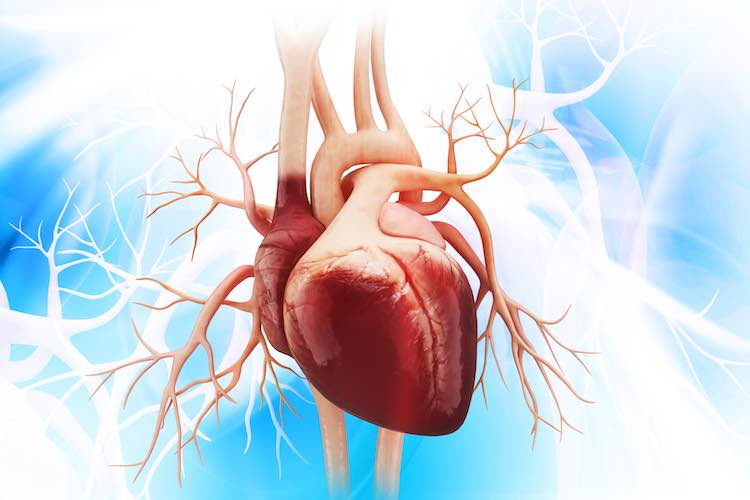

The aim of this project is to apply Machine Learning approaches for classifying whether a person is suffering from Chronic Heart Disease (CHD) or not, using [Cleveland Heart Disease dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) available at the UCI Repository. First, a detailed Exploratory Data Analysis will be performed to summarize the main features of the dataset. Then, after processing the data, different Machine Learning (ML) methods will be compared in terms of accuracy score and Ensamble approaches will be applied to improve the final performances. The ML methods developed are:

1. Logistic Regression;
2. k-nearest neighbors (k-NN);
3. Support Vector Machine (SVM);
4. Naive Bayes;
5. Decision Tree.

In particular, for each Machine Learning method two procedures are used for training and testing:

1. train-test split;
2. *k*-fold cross-validation.

The highest accuracy for both procedures is computed optimizing the values of some parameters such as seed (`random_state`) and number of folds (`n_splits`). Different statistical measures are computed for the best model obtained:

- **confusion matrix**: is a specific table storing the number of true positives (TP), true negative (TN), false positive (FP) and false negative (FN) that have been predicted by a supervised ML method;
- **accuracy** is the proportion of correct predictions (both true positives and true negatives) among the total number of cases examined;
- **recall** (also known as true positive rate) is the proportion of positives that are correctly identified;
- **precision** is the fraction of correct positive prediction over the total of positive predictions;
- **ROC curve** is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The **Area Under the Curve** (AUC) is then computed. 

The best method is selected according to the highest accuracy score. At the end, Ensamble methods are developed to improve the final accuracy reached by single ML apporaches.

### 0. Import libraries and define functions

In [1]:
from matplotlib import pyplot
from pandas import set_option
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from numpy import set_printoptions
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split  

I generated some functions that will be used in following steps.

In [2]:
#function to compute the mean accuracy between train-test split accuracy and k-fold cross-validation accuracy
def mean_acc(model_index,tt_acc,cv_acc):
  mean_model=(tt_acc[model_index]+cv_acc[model_index])/2
  return mean_model

#function to compute the best accuracy in train-test split procedure using different values of seed
def best_seed(x,y,m):
  max_acc=0
  best_seed = 0
  for seed in range(1,20): 
      x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=seed)           
      m.fit(x_train, y_train)            
      r = m.score(x_test, y_test) 
      output_r = r*100.0
      if output_r >= max_acc:
        best_seed = seed
        max_acc = output_r
  return max_acc,best_seed

#function to compute the best accuracy in k-fold cross-validation procedure using different values of seed and number of folds
def best_fold_seed(x,y,m):
  num_folds = [5,10,20,40,70,80,100,120]
  acc=[]
  param = []
  for i in num_folds:
    for seed in range(1,10):
      cvfold=KFold(n_splits=i, random_state=seed, shuffle=True)
      cv_pred = cross_val_predict(m, x, y, cv=cvfold)
      cv_acc = accuracy_score(y, cv_pred)
      param.append([i,seed])
      acc.append(cv_acc*100.0)
  max_acccv=max(acc)
  best_i=acc.index(max_acccv)
  best_folds = param[best_i][0]
  best_seed = param[best_i][1]
  return max_acccv,best_folds,best_seed

### 1. Import file and generate the dataframe

In [3]:
from google.colab import files
uploaded = files.upload()

Saving clev.csv to clev.csv


In [4]:
import pandas as pd
filename='clev.csv'
df = pd.read_csv(filename)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


The *target* field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4. Since the aim of the project is to simply distinguish presence (values 1,2,3,4) from absence (value 0), I proceed with the following mapping:

In [5]:
df['target'] = df.target.map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})

### 2. Exploratory data analysis

#### 2.1. Dataset description

The dataset consists in 303 instances and 14 attributes, including the *target* attribute, referrring to the final output of the prediction.

In [6]:
df.shape

(303, 14)

In [8]:
set_option('display.width', 200)
set_option('display.max_rows', 500)
set_option('display.max_columns', 500)
set_option('precision', 3) 

The attributes can be divided in:

*   numerical values: age, resting blood pressure (*trestbps*), serum cholestoral (*chol*), maximum heart rate achieved (*thalach*), ST depression induced by exercise relative to rest (*oldpeak*);
*   categorical values: sex, chest pain type (*cp*), fasting blood sugar (*fbs*), resting electrocardiographic results (*restecg*), exercise induced angina (*exang*), slope of the peak exercise ST segment (*slope*), the slope of the peak exercise ST segment, number of major vessels (0-3) colored by flourosopy (*ca*), the heart status as retrieved from Thallium test (*thal*). 


In [9]:
names=['age','sex','cp','trestbps', 'chol',	'fbs',	'restecg',	'thalach',	'exang',	'oldpeak',	'slope',	'ca',	'thal',	'target']
cat_att=['sex','cp','fbs','restecg','exang','slope','ca','thal']
num_att=[]
for i in range(len(names)):
  if names[i] not in cat_att:
    num_att.append(names[i])
num_att.remove('target')

#number of numerical attributes
print(len(num_att))

#number of categorical attributes
print(len(cat_att))

5
8


There are 5 numerical attributes and 8 catagorical attributes. 

In [21]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000,303.000,303.000,303.00,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000
mean,54.439,0.680,3.158,131.69,246.693,0.149,0.990,149.607,0.327,1.040,1.601,0.672,4.734,0.459
std,9.039,0.467,0.960,17.60,51.777,0.356,0.995,22.875,0.470,1.161,0.616,0.931,1.933,0.499
min,29.000,0.000,1.000,94.00,126.000,0.000,0.000,71.000,0.000,0.000,1.000,0.000,3.000,0.000
25%,48.000,0.000,3.000,120.00,211.000,0.000,0.000,133.500,0.000,0.000,1.000,0.000,3.000,0.000
50%,56.000,1.000,3.000,130.00,241.000,0.000,1.000,153.000,0.000,0.800,2.000,0.000,3.000,0.000
75%,61.000,1.000,4.000,140.00,275.000,0.000,2.000,166.000,1.000,1.600,2.000,1.000,7.000,1.000
max,77.000,1.000,4.000,200.00,564.000,1.000,2.000,202.000,1.000,6.200,3.000,3.000,7.000,1.000


In [11]:
df.target.value_counts()

0    164
1    139
Name: target, dtype: int64

CHD is diagnosed to a total of 139 individuals while 164 individuals are safe.





#### 2.2. Check for missing values

In [12]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

There are six missing values in the dataset, with 4 belonging to attribute *ca* and 2 to *thal*.  I decided to assign the mean of *thal* and *ca* attributes in place of the null values.

In [13]:
df['thal'] = df.thal.fillna(df.thal.mean())
df['ca'] = df.ca.fillna(df.ca.mean())

#### 2.3. Bivariate analysis

Bivariate analysis is used to investigate the degree of the relationships between each variable in the dataset and the target variable of interest (**between-class correlations**) and among all variables inside each class (**within-class correlations**).

**Between-class correlations**

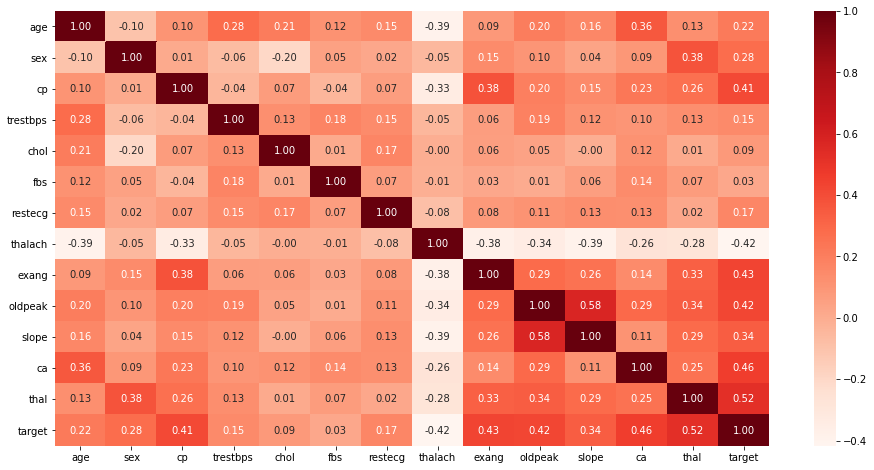

In [14]:
corr =df.corr()
fig, ax =pyplot.subplots(figsize =(16,8))
ax  = sns.heatmap(corr,annot =True,fmt = ".2f", cmap = 'Reds');

In [15]:
corr['target'].sort_values(ascending=False)

target      1.000
thal        0.524
ca          0.458
exang       0.432
oldpeak     0.425
cp          0.414
slope       0.339
sex         0.277
age         0.223
restecg     0.169
trestbps    0.151
chol        0.085
fbs         0.025
thalach    -0.417
Name: target, dtype: float64

Although there are no attributes with strong positive or negative correlation with the target,  *thal*, *ca*, *exang* and *oldpeak* show middle positive correlation, while *thalach* shows middle negative correlation.  

**Within-class correlations**

Two different dataframes are extracted from the original one in order to divide healthy patients (*target* = 0) and not-healthy patients (*target* = 1). 

In [16]:
df_safe = df[df['target'] == 0]
df_CHD = df[df['target'] == 1]

In [17]:
del df_safe['target']
del df_CHD['target']

The within-class correlation is analysed to derive important relationships between attributes in the two different classes.

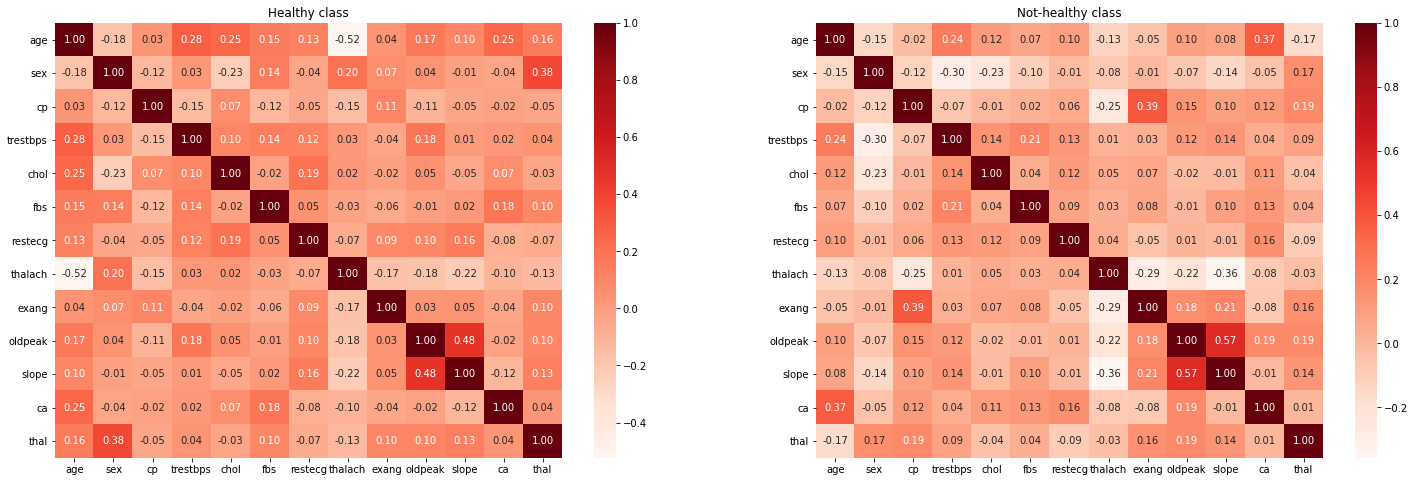

In [18]:
corr_safe =df_safe.corr()
corr_CHD =df_CHD.corr()
fig, ax =pyplot.subplots(1,2, figsize =(25,8))
ax[0].set_title("Healthy class")
sns.heatmap(corr_safe,annot =True,fmt = ".2f", cmap = 'Reds',ax =ax[0])
ax[1].set_title("Not-healthy class")
sns.heatmap(corr_CHD,annot =True,fmt = ".2f", cmap = 'Reds', ax= ax[1])
plt.show()

In both cases, neither strong positive nor negative correlations are visible between attributes. However, in healthy class, *age* and *thalach* attributes show a middle negative correlation of -0.52, demostrating that as age increases the maximuym heart rate achived (thalach) decreases (see scatter plot below). Furthermore, as noticed before, a middle positive correlation of 0.48 is showed by *slope* and *oldpeak* attributes. The same behavoir is visible also in Not-healthy class, even if with a stronger correlation (0.57).

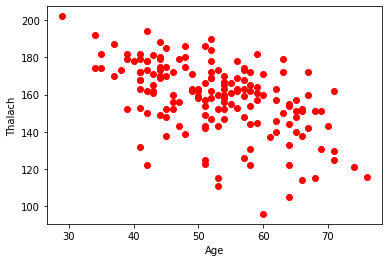

In [19]:
plt.scatter(df_safe['age'], df_safe['thalach'], c='Red')
plt.xlabel('Age')
plt.ylabel('Thalach')
plt.show()

#### 2.4. Univariate analysis of numerical and categorical attributes

* **age**: the age of the individual expressed in years. The boxplot shows that age ranges from 29 to 77 years (mean = 54 years). The distribution plot shows that, as age increases, the probability that a patient is affected by CHD increases too, expecially from 55 years old on. 



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


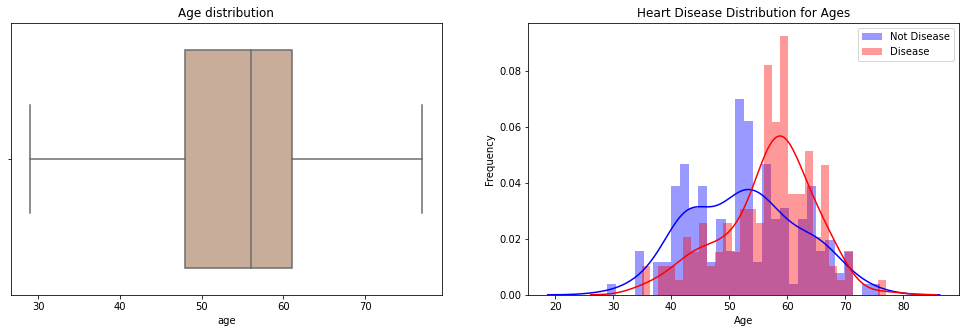

In [22]:
fig,ax=plt.subplots(1,2,figsize=(17,5))
sns.boxplot(x=df['age'], palette = "pink", ax=ax[0])
ax[0].set_title("Age distribution")
sns.distplot(df.age[df['target'] == 0], bins=30, color='blue', label='Not Disease',ax=ax[1])
sns.distplot(df.age[df['target'] == 1], bins=30, color='red', label='Disease',ax=ax[1])
plt.legend()
plt.title('Heart Disease Distribution for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

* **trestbps**: resting blood pressure in mm Hg on admission to the hospital. The boxplot shows that resting blood pressure ranges from 94 to 200 mm Hg. The distribution plot shows that the attribute does not affect significantly the final diagnosis.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


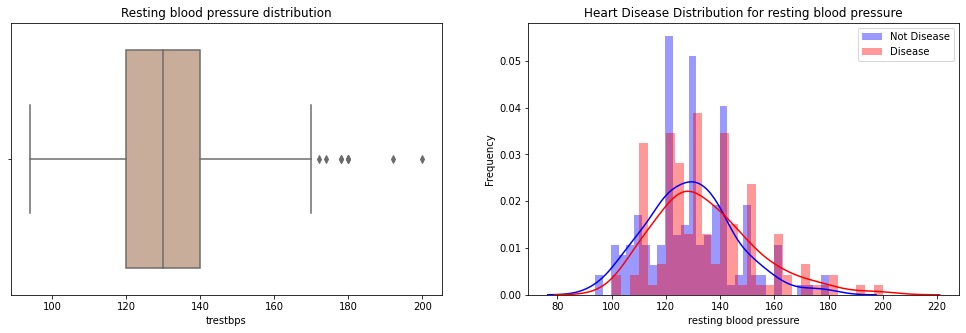

In [23]:
fig,ax=plt.subplots(1,2,figsize=(17,5))
sns.boxplot(x=df['trestbps'], palette = "pink", ax=ax[0])
ax[0].set_title("Resting blood pressure distribution")
sns.distplot(df.trestbps[df['target'] == 0], bins=30, color='blue', label='Not Disease', ax=ax[1])
sns.distplot(df.trestbps[df['target'] == 1], bins=30, color='red', label='Disease',ax=ax[1])
plt.legend()
plt.title('Heart Disease Distribution for resting blood pressure')
plt.xlabel('resting blood pressure')
plt.ylabel('Frequency')
plt.show()

* **chol**: Serum cholesterol in mg/dl. The boxplot shows a mean serum cholesterol of 246.693 mg/dl. As expected from the correlation matrix, the distribution plot shows that cholesterol level does not affect significanlty patient's status. The mean serum cholesterol of the two groups is very similar.



In [32]:
# mean value in healthy group
df.chol[df['target'] == 0].mean()

242.640243902439

In [33]:
# mean value in CHD group
df.chol[df['target'] == 1].mean()

251.4748201438849

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


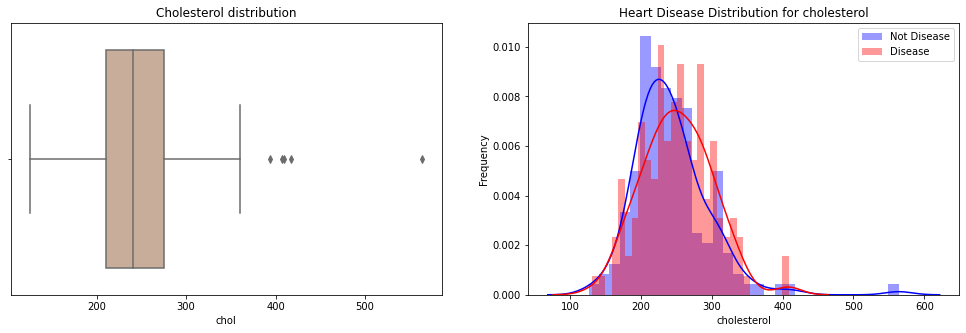

In [34]:
fig,ax=plt.subplots(1,2,figsize=(17,5))
sns.boxplot(x=df['chol'], palette = "pink", ax=ax[0])
ax[0].set_title("Cholesterol distribution")
sns.distplot(df.chol[df['target'] == 0], bins=30, color='blue', label='Not Disease',ax=ax[1])
sns.distplot(df.chol[df['target'] == 1], bins=30, color='red', label='Disease',ax=ax[1])
plt.legend()
plt.title('Heart Disease Distribution for cholesterol')
plt.xlabel('cholesterol')
plt.ylabel('Frequency')
plt.show()

* **oldpeak**: ST depression induced by exercise relative to rest. ST depression refers to a finding on an electrocardiogram, wherein the trace in the ST segment is abnormally low below the baseline. In general, people showing an ST depression around 0 are healthy, while patients with a heart disease have reported ST depression rate around 0-4, as shown by the distribution plot.



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


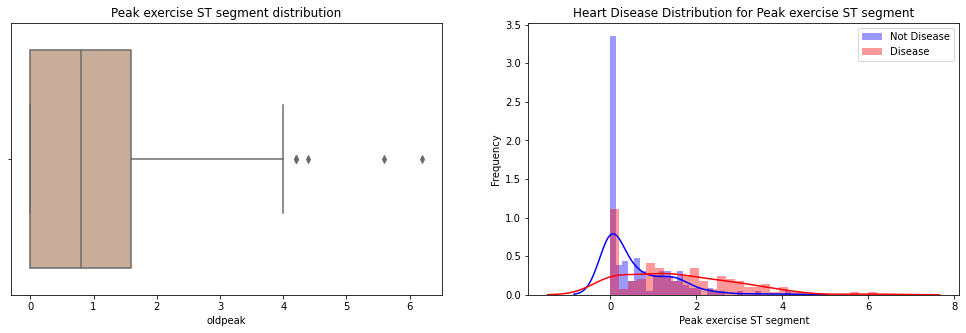

In [35]:
fig,ax=plt.subplots(1,2,figsize=(17,5))
sns.boxplot(x=df['oldpeak'], palette = "pink", ax=ax[0])
ax[0].set_title("Peak exercise ST segment distribution")
sns.distplot(df.oldpeak[df['target'] == 0], bins=30, color='blue', label='Not Disease')
sns.distplot(df.oldpeak[df['target'] == 1], bins=30, color='red', label='Disease')
plt.legend()
plt.title('Heart Disease Distribution for Peak exercise ST segment')
plt.xlabel('Peak exercise ST segment')
plt.ylabel('Frequency')
plt.legend()
plt.show()

* **thalach**: maximum heart rate achieved by an individual. The boxplot shows a mean maximum heart rate of 149. The distrbution plot shows that, healthy people have a quite higher maximum heart rate (around 160) compared to the maximum heart rate (around 150) of patients with a heart disease.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


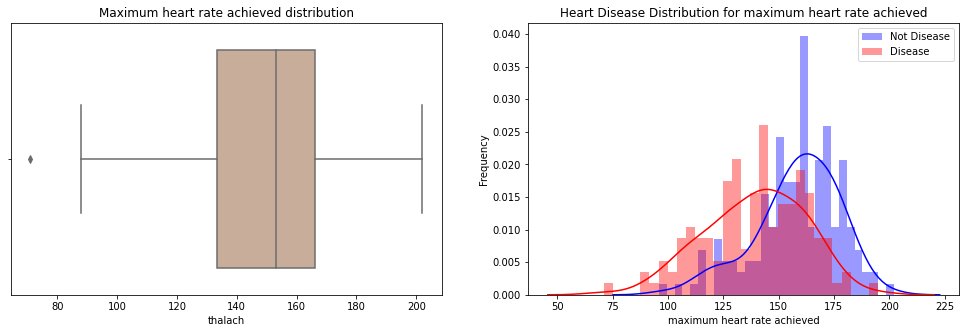

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(17,5))
sns.boxplot(x=df['thalach'], palette = "pink", ax=ax[0])
ax[0].set_title("Maximum heart rate achieved distribution")
sns.distplot(df.thalach[df['target'] == 0], bins=30, color='blue', label='Not Disease')
sns.distplot(df.thalach[df['target'] == 1], bins=30, color='red', label='Disease')
plt.legend()
plt.title('Heart Disease Distribution for maximum heart rate achieved')
plt.xlabel('maximum heart rate achieved')
plt.ylabel('Frequency')
plt.show()

**Categorical variables**:


1.  **sex**: 0 female, 1 male. Level wise comparison for target feature shows men are more likely to have a heart disease than women.

2. **cp**: Chest pain type (Categorical with 4 levels-Type 1, Type 2, Type 3 and Type 4) Type 1:typical angina Type 2:atypical angina Type 3:non-anginal pain Type 4:asymptomatic. The most of healthy people has had a non-anginal pain while patients suffering from CHD have had Type 4 cheast pain.

3. **fbs**: Fasting blood sugar > 120 mg/dl (Categorical with 2 levels-1,0). The barplot below suggests that the fasting blood sugar level may not be a deciding factor for having a heart disease or not.

4. **restecg**: Resting electrocardiographic results (Categorical with 3 levels-0(Normal), 1( having ST-T wave abnormality), 2(showing probable or definite left ventricular hypertrophy)).Healthy people showed normal ECG results while patients with a heart disease showed a ECG result of level 2

5. **exang**: Exercise induced angina (Categorical with 2 levels-1, 0). Having a exercise induced angina for a patient with a heart disease is more dangerous than a patient without a heart disease.This shows having a exercise induced angina may be a deciding factor for having a heart disease.

6. **slope**: The slope of the peak exercise ST segment (categorical with 3 levels- 1 (Upsloping), 2 (flatsloping or horizontal), 3 (downsloping). Majority of people from healthy group have had up sloping exercise while majority of patients with a heart disease have had flat exercise ST segment.

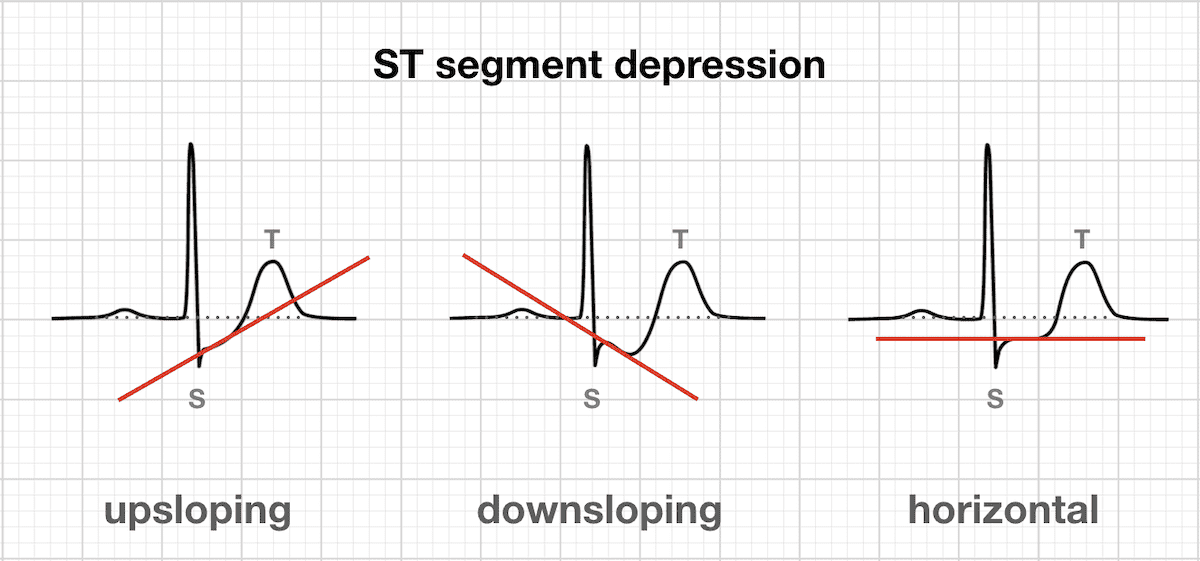

7. **ca**: Number of major vessels (0-3) colored by flourosopy (Categorical with 4 levels-0, 1, 2, 3). Healthy people showed no major vessels colored by flouroscopy. 

8. **thal**: The heart status as retrieved from Thallium test (Categorical with 3 levels-3 normal; 6 fixed defect; 7 reversable defect). Healthy people mostly showed a normal heart status while sick people showed mostly a reversible defect condition.



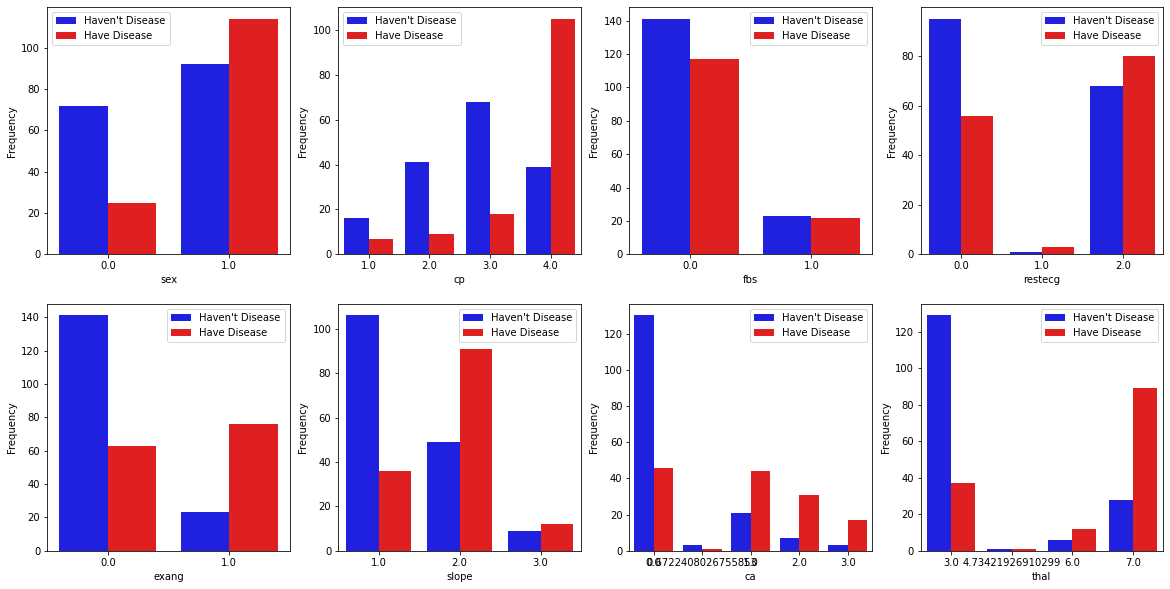

In [38]:
fig, axes = plt.subplots(2,4, figsize=(20,10))
for i, axi in enumerate(axes.flat):
    sns.countplot(x=cat_att[i], hue='target', data=df, palette=['blue','red'] , ax=axi) 
    axi.set(ylabel='Frequency')
    axi.legend(["Haven't Disease", "Have Disease"])

### 3. Data processing and Feature importance


**Scale of the data**

In [39]:
from sklearn.preprocessing import StandardScaler
s_sc = StandardScaler()
df[num_att] = s_sc.fit_transform(df[num_att])
dataset=df
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.949,1.0,1.0,0.758,-0.265,1.0,2.0,0.017,0.0,1.087,3.0,0.0,6.0,0
1,1.392,1.0,4.0,1.611,0.760,0.0,2.0,-1.822,1.0,0.397,2.0,3.0,3.0,1
2,1.392,1.0,4.0,-0.665,-0.342,0.0,2.0,-0.902,1.0,1.346,2.0,2.0,7.0,1
3,-1.933,1.0,3.0,-0.096,0.064,0.0,0.0,1.637,0.0,2.123,3.0,0.0,3.0,0
4,-1.489,0.0,2.0,-0.096,-0.826,0.0,2.0,0.981,0.0,0.311,1.0,0.0,3.0,0


**Feature Importance**

In [40]:
X = dataset.drop('target', axis=1)
Y = dataset.target

Two methods are used to derive the five most important features in the dataset. The first method is feature ranking with recursive feature elimination (**RFE**): given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), RFE is able to select features by recursively considering smaller and smaller sets of features. The second method is **extra-trees classifier** where the importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.

According with RFE, the top 5 features are: *sex*, *cp*, *exang*, *slope* and *ca*. 

In [44]:
modelFI = LogisticRegression(solver = 'lbfgs', max_iter = 500)
rfeFI = RFE(modelFI, 5)
fitFI = rfeFI.fit(X, Y)
print(names)
print("Num Features: %d" % fitFI.n_features_)
print("Selected Features: %s" % fitFI.support_)
print("Feature Ranking: %s" % fitFI.ranking_)

['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
Num Features: 5
Selected Features: [False  True  True False False False False False  True False  True  True
 False]
Feature Ranking: [9 1 1 4 8 2 7 3 1 5 1 1 6]


The five most important features selected by `ExtraTreesClassifiers` are, in decreasing order: *thal*, *ca*, *cp*, *exang* and *thalach*. 

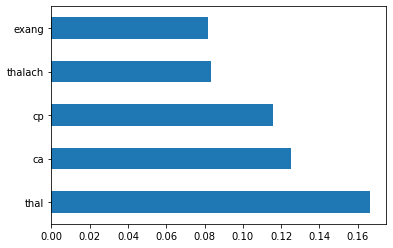

In [45]:
modelET = ExtraTreesClassifier()
modelET.fit(X,Y)
(pd.Series(modelET.feature_importances_, index=X.columns)
   .nlargest(5)
   .plot(kind='barh')) 

As we can see, both methods agree on three features out of five (*cp*,*exang* and *ca*). 

### 4. **Machine Learning model:** Logistic Regression

#### 4.1. Logistic Regression with train-test split

**Parameter optimization**

Different values of seeds are employed in the training procedure. The optimal value of seed is the one giving the highest accuracy score in the testing procedure.

In [46]:
resLRtt=best_seed(X,Y,LogisticRegression())
print("Highest accuracy reached is "+ str(resLRtt[0]) + " % with seed "+ str(resLRtt[1]))

Highest accuracy reached is 89.0 % with seed 5


**Training and Testing**

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=5)

In [48]:
modelLRtt = LogisticRegression()
modelLRtt.fit(X_train, Y_train)
LRtt_pred = modelLRtt.predict(X_test)
LRtt_acc = accuracy_score(Y_test, LRtt_pred)
LRtt_rec = recall_score(Y_test, LRtt_pred)
LRtt_prec = precision_score(Y_test, LRtt_pred)

**Statistics**: Classification Report

In [49]:
  reportLR = classification_report(Y_test, LRtt_pred)   
  print(reportLR)

              precision    recall  f1-score   support

           0       0.87      0.95      0.91        58
           1       0.92      0.81      0.86        42

    accuracy                           0.89       100
   macro avg       0.90      0.88      0.88       100
weighted avg       0.89      0.89      0.89       100



**Statistics:** Confusion Matrix


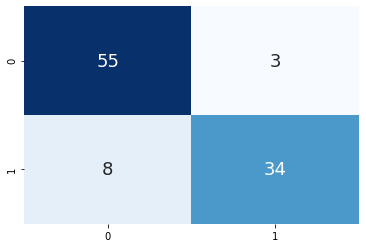

In [50]:
matrix1 = confusion_matrix(Y_test, LRtt_pred)
sns.heatmap(matrix1,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})  
plt.show()

**Statistics:** ROC curve and AUC

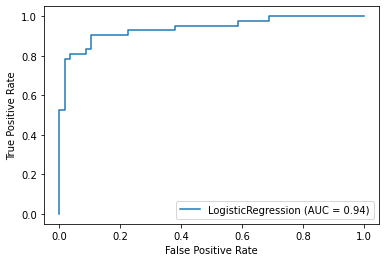

In [51]:
from sklearn import metrics
metrics.plot_roc_curve(modelLRtt, X_test, Y_test) 

#### 4.2. Logistic Regression with *k*-fold cross-validation

**Parameter optimization**

Different values of seeds and number of folds are employed in the training procedure. The optimal combination of such parameters is the one giving the highest accuracy score in the testing procedure.

In [52]:
resLRcv=best_fold_seed(X,Y,LogisticRegression())
print("Highest accuracy reached is "+ str(resLRcv[0]) + " % with seed "+ str(resLRcv[2])+ " and # of folds "+str(resLRcv[1]))

Highest accuracy reached is 84.15841584158416 % with seed 4 and # of folds 5


**Training and Testing**

In [53]:
cvfoldLR=KFold(n_splits=5, random_state=4, shuffle=True)
cv_predLR = cross_val_predict(LogisticRegression(), X, Y, cv=cvfoldLR)

**Statistics**: accuracy, recall and precision

In [54]:
cv_accLR = accuracy_score(Y, cv_predLR)  
cv_recLR=recall_score(Y,cv_predLR) 
cv_precLR = precision_score(Y, cv_predLR) 
print("Accuracy: "+str(cv_accLR*100)+" %")
print("Recall: "+str(cv_recLR*100)+" %")
print("Precision: "+str(cv_precLR*100)+" %")

Accuracy: 84.15841584158416 %
Recall: 79.85611510791367 %
Precision: 84.7328244274809 %


**Statistics:** Confusion Matrix

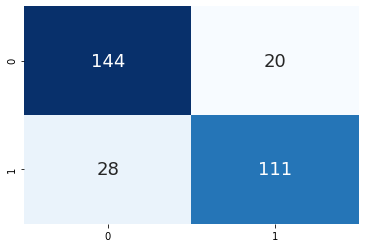

In [55]:
matrix2 = confusion_matrix(Y, cv_predLR)
sns.heatmap(matrix2,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})
plt.show()

#### 4.3. Final Results

In [56]:
results_df = pd.DataFrame(data=[["Logistic Regression", LRtt_acc*100, cv_accLR*100, LRtt_rec*100,cv_recLR*100, LRtt_prec*100, cv_precLR*100]], 
                          columns=['Model', 'TT Accuracy %', 'CV Accuracy %','TT Recall %','CV Recall %','TT Precision %','CV Precision %'])
results_df

,Model,TT Accuracy %,CV Accuracy %,TT Recall %,CV Recall %,TT Precision %,CV Precision %
0,Logistic Regression,89.0,84.158,80.952,79.856,91.892,84.733


### 5. **Machine Learning model:** K-Neighbors

#### 5.1. K-Neighbors with train-test split

**Parameter optimization**

In [57]:
resknntt = best_seed(X,Y,KNeighborsClassifier())
print("Highest accuracy reached is "+ str(resknntt[0]) + " % with seed "+ str(resknntt[1]))

Highest accuracy reached is 85.0 % with seed 19


**Training and Testing**

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=19)

In [61]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, Y_train)
knn_pred = knn_clf.predict(X_test)
knn_acc = accuracy_score(Y_test, knn_pred)
knn_prec = precision_score (Y_test, knn_pred)
knn_rec = recall_score(Y_test, knn_pred)

**Statistics**: Classification Report

In [62]:
knn_report = classification_report(Y_test, knn_pred)   
print(knn_report)

              precision    recall  f1-score   support

           0       0.84      0.86      0.85        50
           1       0.86      0.84      0.85        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



**Statistics:** Confusion Matrix

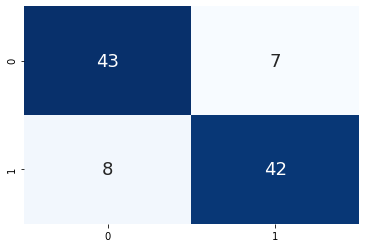

In [63]:
matrix4 = confusion_matrix(Y_test, knn_pred)
sns.heatmap(matrix4,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})  
plt.show()

**Statistics:** ROC curve and AUC

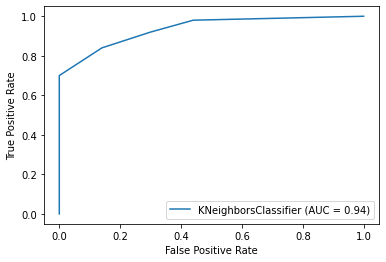

In [64]:
metrics.plot_roc_curve(knn_clf, X_test, Y_test)

#### 5.2. K-Neighbors with *k*-fold cross-validation

**Parameter optimization**

In [65]:
resknncv=best_fold_seed(X,Y,KNeighborsClassifier())
print("Highest accuracy reached is "+ str(resknncv[0]) + " % with seed "+ str(resknncv[2])+ " and # of folds "+str(resknncv[1]))

Highest accuracy reached is 80.85808580858085 % with seed 3 and # of folds 5


**Training and Testing**

In [66]:
cvfoldknn=KFold(n_splits=5, random_state=3, shuffle=True)
cv_predknn = cross_val_predict(KNeighborsClassifier(), X, Y, cv=cvfoldknn)

**Statistics**: accuracy, recall and precision

In [67]:
cv_accknn = accuracy_score(Y, cv_predknn)   
cv_recknn = recall_score(Y, cv_predknn) 
cv_precknn = precision_score(Y, cv_predknn)
print("Accuracy: "+str(cv_accknn*100)+" %")
print("Recall: "+str(cv_recknn*100)+" %")
print("Precision: "+str(cv_precknn*100)+" %")

Accuracy: 80.85808580858085 %
Recall: 76.97841726618705 %
Precision: 80.45112781954887 %


**Statistics:** Confusion Matrix

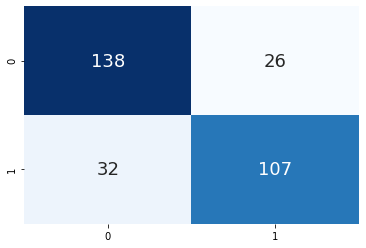

In [68]:
matrix5 = confusion_matrix(Y, cv_predknn)
sns.heatmap(matrix5,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})
plt.show()

#### 5.3. Final Results

In [69]:
results_df1 = pd.DataFrame(data=[["K-nearest neighbours", knn_acc*100, cv_accknn*100, knn_rec*100,cv_recknn*100, knn_prec*100, cv_precknn*100]], 
                          columns=['Model', 'TT Accuracy %', 'CV Accuracy %','TT Recall %','CV Recall %','TT Precision %','CV Precision %'])
results_df = results_df.append(results_df1, ignore_index=True)

### 6. **Machine Learning model**: SVM

#### 6.1. SVM with train-test split

**Parameter optimization**

In this case, seed parameter optimization is performed togheter with optimization of SVM kernel. In particular, four different kernel functions have been tested:
- linear kernel;
- polynomial kernel;
- radial basis function (RBF) kernel;
- sigmoid kernel.

In [70]:
k = ['linear', 'poly', 'rbf','sigmoid']

In [71]:
for ker in k:
  resSVMtt=best_seed(X,Y,SVC(kernel = ker))
  print(ker+ " kernel: highest accuracy reached is "+ str(resSVMtt[0]) + " % with seed "+ str(resSVMtt[1]))

linear kernel: highest accuracy reached is 87.0 % with seed 6
poly kernel: highest accuracy reached is 90.0 % with seed 16
rbf kernel: highest accuracy reached is 87.0 % with seed 16
sigmoid kernel: highest accuracy reached is 52.0 % with seed 12


Polynomial kernel returns the highest accuracy with `random_state` set to 16.

**Training and Testing**

In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=16)

In [73]:
modelSVM = SVC(kernel = 'poly')
modelSVM.fit(X_train, Y_train)
SVM_pred = modelSVM.predict(X_test)

**Statistics:** Classification Report

In [74]:
SVM_report = classification_report(Y_test, SVM_pred)
SVM_acc = accuracy_score(Y_test, SVM_pred)
SVM_prec = precision_score(Y_test, SVM_pred)
SVM_rec = recall_score (Y_test, SVM_pred)
print(SVM_report)

              precision    recall  f1-score   support

           0       0.91      0.94      0.93        67
           1       0.87      0.82      0.84        33

    accuracy                           0.90       100
   macro avg       0.89      0.88      0.89       100
weighted avg       0.90      0.90      0.90       100



**Statistics:** Confusion Matrix

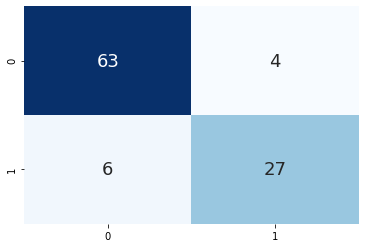

In [75]:
matrix6 = confusion_matrix(Y_test, SVM_pred)
sns.heatmap(matrix6,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})  
plt.show()

**Statistics:** ROC curve and AUC

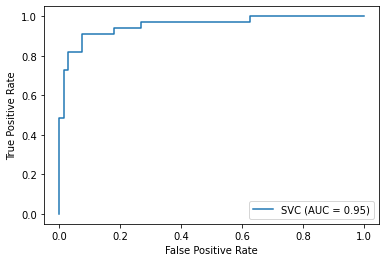

In [76]:
metrics.plot_roc_curve(modelSVM, X_test, Y_test)

#### 6.2. SVM with *k*-fold cross-validation

**Parameter optimization**

In [79]:
#k = ['linear', 'poly', 'rbf','sigmoid']
for ker in k:
  resSVMcv=best_fold_seed(X,Y,SVC(kernel = ker))
  print(str(ker)+": Highest accuracy reached is "+ str(resSVMcv[0]) + " % with seed "+ str(resSVMcv[2])+ " and # of folds "+str(resSVMcv[1]))

linear: Highest accuracy reached is 84.15841584158416 % with seed 2 and # of folds 5
poly: Highest accuracy reached is 84.81848184818482 % with seed 2 and # of folds 5
rbf: Highest accuracy reached is 83.4983498349835 % with seed 6 and # of folds 5
sigmoid: Highest accuracy reached is 44.884488448844884 % with seed 5 and # of folds 5


**Training and Testing**



In [80]:
cvfoldSVM=KFold(n_splits=5, random_state=2, shuffle=True)
cv_predSVM = cross_val_predict(SVC(kernel='poly'), X, Y, cv=cvfoldSVM) 

**Statistics:** accuracy, recall and precision

In [81]:
cv_accSVM = accuracy_score(Y, cv_predSVM)
cv_recSVM = recall_score(Y, cv_predSVM)
cv_precSVM = precision_score(Y, cv_predSVM)
print("Accuracy: "+str(cv_accSVM*100)+" %")
print("Recall: "+str(cv_recSVM*100)+" %")
print("Precision: "+str(cv_precSVM*100)+" %") 

Accuracy: 84.81848184818482 %
Recall: 76.97841726618705 %
Precision: 88.42975206611571 %


**Statistics:** Confusion Matrix

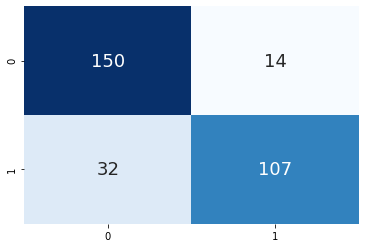

In [82]:
matrix7 = confusion_matrix(Y, cv_predSVM)
sns.heatmap(matrix7,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})
plt.show()

#### 6.3. Final Results

In [83]:
results_df2 = pd.DataFrame(data=[["SVM", SVM_acc*100, cv_accSVM*100, SVM_rec*100,cv_recSVM*100, SVM_prec*100, cv_precSVM*100]], 
                          columns=['Model', 'TT Accuracy %', 'CV Accuracy %','TT Recall %','CV Recall %','TT Precision %','CV Precision %'])
results_df = results_df.append(results_df2, ignore_index=True)

### 7. **Machine Learning model:** Naive Bayes

#### 7.1. Naive Bayes with train-test split

**Parameter optimization**

In [84]:
resGNBtt = best_seed(X,Y,GaussianNB())
print("Highest accuracy reached is "+ str(resGNBtt[0]) + " % with seed "+ str(resGNBtt[1]))

Highest accuracy reached is 89.0 % with seed 5


**Training and Testing**




In [85]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=5)

In [86]:
modelGNB = GaussianNB()
modelGNB.fit(X_train, Y_train)
GNB_pred = modelGNB.predict(X_test)

**Statistics:** Classification Report

In [87]:
GNB_report = classification_report(Y_test, GNB_pred) 
GNB_acc = accuracy_score(Y_test, GNB_pred) 
GNB_prec = precision_score(Y_test, GNB_pred) 
GNB_rec = recall_score(Y_test, GNB_pred) 
print(GNB_report)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        58
           1       0.90      0.83      0.86        42

    accuracy                           0.89       100
   macro avg       0.89      0.88      0.89       100
weighted avg       0.89      0.89      0.89       100



**Statistics:** Confusion Matrix

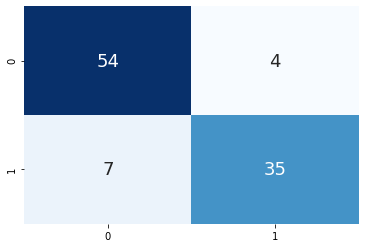

In [88]:
matrix8 = confusion_matrix(Y_test, GNB_pred)
sns.heatmap(matrix8,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})  
plt.show()

**Statistics:** ROC curve and AUC

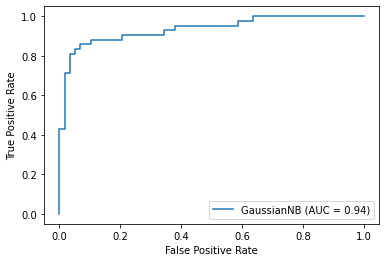

In [89]:
metrics.plot_roc_curve(modelGNB, X_test, Y_test)

#### 7.2. Naive Bayes with *k*-fold cross-validation

**Parameter optimization**

In [90]:
resGNBcv=best_fold_seed(X,Y,GaussianNB())
print("Highest accuracy reached is "+ str(resGNBcv[0]) + " % with seed "+ str(resGNBcv[2])+ " and # of folds "+str(resGNBcv[1]))

Highest accuracy reached is 85.14851485148515 % with seed 6 and # of folds 10


**Training and Testing with optimal parameters**

In [91]:
cvfoldGNB=KFold(n_splits=10, random_state=6, shuffle=True)
cv_predGNB = cross_val_predict(modelGNB, X, Y, cv=cvfoldGNB)   

**Statistics:** accuracy, recall and precision

In [92]:
cv_accGNB = accuracy_score(Y, cv_predGNB)  
cv_recGNB = recall_score(Y, cv_predGNB) 
cv_precGNB = precision_score(Y, cv_predGNB)
print("Accuracy: "+str(cv_accGNB*100)+" %")
print("Recall: "+str(cv_recGNB*100)+" %")
print("Precision: "+str(cv_precGNB*100)+" %")

Accuracy: 85.14851485148515 %
Recall: 79.85611510791367 %
Precision: 86.71875 %


**Statistics:** Confusion Matrix

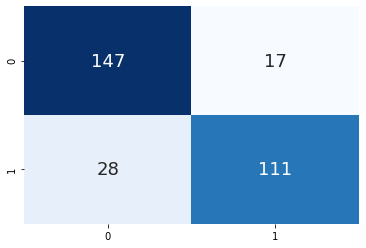

In [93]:
matrix9 = confusion_matrix(Y, cv_predGNB)
sns.heatmap(matrix9,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})
plt.show()

#### 7.3. Final Results

In [94]:
results_df3 = pd.DataFrame(data=[["Naive Bayes", GNB_acc*100, cv_accGNB*100, GNB_rec*100,cv_recGNB*100, GNB_prec*100, cv_precGNB*100]], 
                          columns=['Model', 'TT Accuracy %', 'CV Accuracy %','TT Recall %','CV Recall %','TT Precision %','CV Precision %'])
results_df = results_df.append(results_df3, ignore_index=True)

### 8. **Machine Learning model:** Decision Tree

#### 8.1. Decision Tree with train-test split

**Parameter optimization**

In [104]:
resDTtt = best_seed(X,Y,DecisionTreeClassifier())
print("Highest accuracy reached is "+ str(resDTtt[0]) + " % with seed "+ str(resDTtt[1]))

Highest accuracy reached is 81.0 % with seed 9


**Training and Testing**

In [132]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=9)

In [134]:
modelDT = DecisionTreeClassifier()
modelDT.fit(X_train, Y_train)
DT_pred = modelDT.predict(X_test)

**Statistics:** Classification Report

In [135]:
DT_report = classification_report(Y_test, DT_pred) 
DT_acc = accuracy_score(Y_test,DT_pred)
DT_rec = recall_score(Y_test,DT_pred)
DT_prec = precision_score(Y_test,DT_pred)
print(DT_report)

              precision    recall  f1-score   support

           0       0.84      0.79      0.82        53
           1       0.78      0.83      0.80        47

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100



**Statistics:** Confusion Matrix

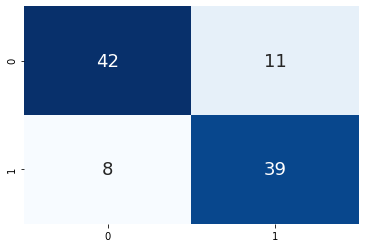

In [136]:
matrix10 = confusion_matrix(Y_test, DT_pred)
sns.heatmap(matrix10,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})  
plt.show()

**Statistics:** ROC curve and AUC

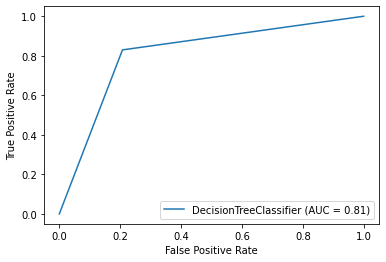

In [137]:
metrics.plot_roc_curve(modelDT, X_test, Y_test)

#### 8.2. Decision Tree with *k*-fold cross-validation

**Parameter optimization**

In [138]:
resDTcv=best_fold_seed(X,Y,DecisionTreeClassifier())
print("Highest accuracy reached is "+ str(resDTcv[0]) + " % with seed "+ str(resDTcv[2])+ " and # of folds "+str(resDTcv[1]))

Highest accuracy reached is 76.89768976897689 % with seed 4 and # of folds 10


**Training and Testing**

In [139]:
cvfoldDT=KFold(n_splits=10, random_state=4, shuffle=True)
cv_predDT = cross_val_predict(DecisionTreeClassifier(), X, Y, cv=cvfoldDT)  

**Statistics:** accuracy, recall and precision

In [140]:
cv_accDT = accuracy_score(Y, cv_predDT)
cv_recDT = recall_score(Y, cv_predDT)
cv_precDT = precision_score(Y, cv_predDT)
print("Accuracy: "+str(cv_accDT*100)+" %")
print("Recall: "+str(cv_recDT*100)+" %")
print("Precision: "+str(cv_precDT*100)+" %")

Accuracy: 76.89768976897689 %
Recall: 74.10071942446042 %
Precision: 75.18248175182481 %


**Statistics:** Confusion Matrix

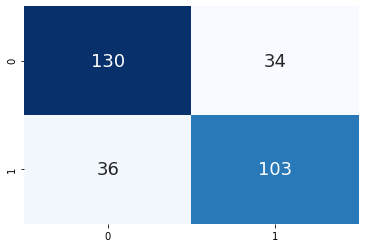

In [141]:
matrix11 = confusion_matrix(Y, cv_predDT)
sns.heatmap(matrix11,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})
plt.show()

#### 8.3. Final Results

In [142]:
results_df4 = pd.DataFrame(data=[["Decision Tree", DT_acc*100, cv_accDT*100, DT_rec*100,cv_recDT*100, DT_prec*100, cv_precDT*100]], 
                          columns=['Model', 'TT Accuracy %', 'CV Accuracy %','TT Recall %','CV Recall %','TT Precision %','CV Precision %'])
results_df = results_df.append(results_df4, ignore_index=True)

### 9. Models comparison

The table below shows the final accuracies for each Machine Learning algorithm in both train-test split and *k*-fold cross-validation. A visual inspection of such table is provided in the histograms below.

In [143]:
results_df

,Model,TT Accuracy %,CV Accuracy %,TT Recall %,CV Recall %,TT Precision %,CV Precision %
0,Logistic Regression,89.0,84.158,80.952,79.856,91.892,84.733
1,K-nearest neighbours,85.0,80.858,84.000,76.978,85.714,80.451
2,SVM,90.0,84.818,81.818,76.978,87.097,88.430
3,Naive Bayes,89.0,85.149,83.333,79.856,89.744,86.719
4,Decision Tree,81.0,76.898,82.979,74.101,78.000,75.182


In [144]:
ML_algos = ['Logistic Regression', 'K-nearest neighbours', 'SVM', 'Naive Bayes', 'Decision Trees']

In [145]:
all_resultsTTacc=results_df['TT Accuracy %']
all_resultsCVacc=results_df['CV Accuracy %']

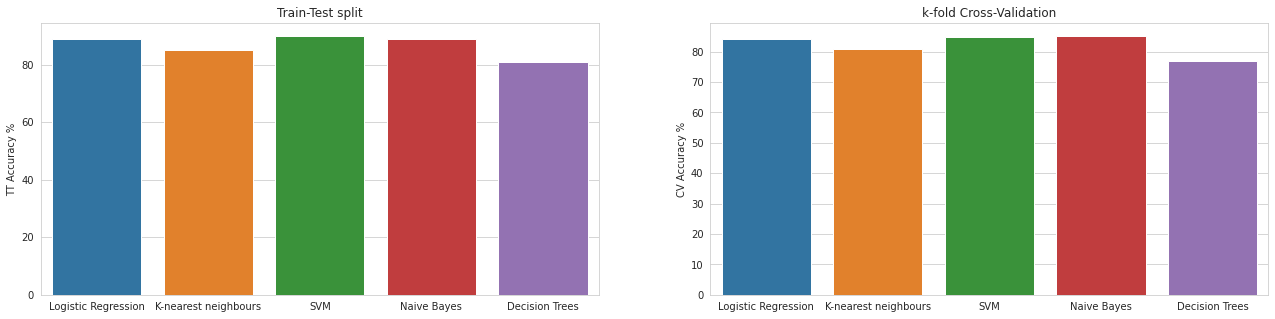

In [156]:
fig,ax=plt.subplots(1,2,figsize=(22,5))
sns.set_style("whitegrid")
sns.barplot(x=ML_algos, y=all_resultsTTacc, ax=ax[0])
ax[0].set_title("Train-Test split")
plt.yticks()
plt.ylabel("Accuracy")
#plt.xlabel("Algorithms")
plt.yticks()
ax[1].set_title("k-fold Cross-Validation")
plt.ylabel("Accuracy")
#plt.xlabel("Algorithms")
sns.barplot(x=ML_algos, y=all_resultsCVacc, ax=ax[1])
plt.show()



The means among the accuracies resulting in train-test split and *k*-fold cross-validation procedures are calculated for each ML algorithm and then plotted:

Logistic Regression 86.57920792079207
K-nearest neighbours 82.92904290429043
SVM 87.40924092409242
Naive Bayes 87.07425742574257
Decision Trees 78.94884488448844


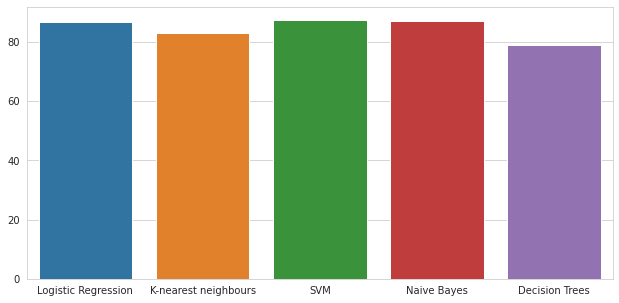

In [147]:
plt.figure(figsize=(10.5,5))
mean_accuracies=[]
for i in range(len(ML_algos)):
  print(ML_algos[i]+" "+str(mean_acc(i,all_resultsTTacc,all_resultsCVacc)))
  mean_accuracies.append(mean_acc(i,all_resultsTTacc,all_resultsCVacc))
ax = sns.barplot(x=ML_algos, y=mean_accuracies)
plt.show()

As a results:

*   for almost all Machine Learning models, train-test split gives higher performances in terms of accuracy score with respect to *k*-fold cross-validation, even if with small differences;
*   the highest mean accuracy is reached by SVM (87.41 %), which is immediantly followed by Naive Bayes (87.07 %).



### 10. Ensamble methods

Ensamble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone. The most common Ensamble methods that will be employed in the following steps are:


*   **Bagging** involves having each model in the ensemble vote with equal weight;
*   **Boosting** involves incrementally building an ensemble by training each new model instance to emphasize the training instances that previous models mis-classified;
*   **Voting** trains on an ensemble of numerous models and predicts an output (class) based on their highest probability of chosen class as the output.



#### 10.1. Bagging Classifier

**Bagged Decision Trees**

In [157]:
num_trees = 100
modelBC = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=num_trees, random_state=4, bootstrap = True)
resultsBC = cross_val_score(modelBC, X, Y, cv=cvfoldDT)
print("Accuracy: "+str(resultsBC.mean()*100)+ " %")

Accuracy: 81.81720430107526 %


Bagging classifier returns an higher value of accuracy with respect to *k*-fold cross-validation accuracy (76.898 %) of Decision Tree Classifier. 

**Random Forest Classifier**



In [158]:
num_trees = 100
#max_features = 5
for i in range(2,14):
  modelRFC = RandomForestClassifier(n_estimators=num_trees, max_features=i)
  resultsRFC = cross_val_score(modelRFC, X, Y, cv=cvfoldDT)
  print("Accuracy: "+str(resultsRFC.mean()*100)+ " %")

Accuracy: 83.11827956989248 %
Accuracy: 82.4731182795699 %
Accuracy: 82.46236559139784 %
Accuracy: 81.79569892473118 %
Accuracy: 82.15053763440862 %
Accuracy: 81.81720430107526 %
Accuracy: 81.17204301075269 %
Accuracy: 80.82795698924731 %
Accuracy: 82.7956989247312 %
Accuracy: 80.49462365591398 %
Accuracy: 81.48387096774194 %
Accuracy: 80.83870967741935 %


Random Forest Classifier returns, for different number of maximum features selected, accuracies in the range 80-83%.

**ExtraTree Classifier**

In [159]:
num_trees = 100
for i in range(2,14):
  modelETC = ExtraTreesClassifier(n_estimators=num_trees, max_features=i)
  resultsETC = cross_val_score(modelETC, X, Y, cv=cvfoldDT)
  print("Accuracy: "+str(resultsETC.mean()*100)+" %")

Accuracy: 83.12903225806451 %
Accuracy: 83.79569892473117 %
Accuracy: 80.82795698924731 %
Accuracy: 81.15053763440861 %
Accuracy: 82.79569892473117 %
Accuracy: 81.50537634408602 %
Accuracy: 82.7956989247312 %
Accuracy: 81.18279569892472 %
Accuracy: 79.84946236559139 %
Accuracy: 80.83870967741935 %
Accuracy: 81.13978494623655 %
Accuracy: 81.15053763440861 %


Accuracy scores increase w.r.t. the single DecisionTree Classifier. Accuracy is in the range 79.84-83.79 % changing the number of maximum features considered. 

#### 10.2. Boosting Classifier



**Stochastic Gradient Boosting**

In [160]:
seed = 7
num_trees = 100
kfold = KFold(n_splits=70, random_state=seed,shuffle=True)
model = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: "+str(results.mean()*100)+" %")

Accuracy: 80.5 %


Also in this case, Boosting classifier, as Ensamble method, increases the accuracy w.r.t. the *k*-fold cross-validation of Decision Tree Classifier.

#### 10.3. Voting Classifier

In [161]:
from sklearn.ensemble import VotingClassifier
estimators = []
model1 = LogisticRegression()
estimators.append(( 'logistic' , model1))
model2 = DecisionTreeClassifier()
estimators.append(( 'DT' , model2))
model3 = SVC()
estimators.append(( 'svm' , model3))
model4 = GaussianNB()
estimators.append(('NB', model4))
model5 = KNeighborsClassifier()
estimators.append(('KNN', model5))

#with train-test split
ensemble = VotingClassifier(estimators)
ensemble.fit(X_train, Y_train)
predEN = ensemble.predict(X_test)
accEN = accuracy_score(Y_test, predEN)
print("Accuracy train-test split: "+str(accEN*100)+ " %")

#with k-fold cross-validation
kfold = KFold(n_splits=70, random_state=7, shuffle=True)
ensembleCV = VotingClassifier(estimators)
resultsCV = cross_val_score(ensembleCV, X, Y, cv=kfold)
print("Accuracy k-fold cross-validation: "+ str(resultsCV.mean()*100) + " %")

Accuracy train-test split: 81.0 %
Accuracy k-fold cross-validation: 82.42857142857143 %
